In [1]:
from multiprocessing import Pool
import numpy as np
from graph import Circle, Grid, RandomRegular, GraphByDegrees, ErdosRenyi, ScaleFree, SmallWorld
from viz import draw_data
from utils import Timer, partition
from engine import fun
from engine_mono import fun_mono
from engine_sum import fun_sum
from engine_tot import fun_tot
from graph_toolset import coreness, degs, biggest_degs
import jupyternotify
import random
import matplotlib.cm as cm
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

# from scipy.misc import imresize
"""
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
"""
import matplotlib.pyplot as plt


from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

import pickle

%matplotlib notebook

<IPython.core.display.Javascript object>

In [2]:
def total(graph, keys):
    res = biggest_degs(graph, list(filter(lambda x: isinstance(x, int), keys)))
    if 'rho' in keys:
        res['rho'] = graph.V
    if 'l' in keys:
        res['l'] = graph.V
    
    return res

In [3]:
def calc(fun_name, alphas, bs, graphs, T, init_type='01', set_builder=total, keys=['total'], pool_size=32):
    pool = Pool(pool_size)
    
    res = dict()
    for key in keys:
        res[key] = []

    timer = Timer()
    
    now = 0
    
    for graph in graphs:
        local_timer = Timer()
        
        sets = set_builder(graph, keys)
        
        points = [(graph, b, alpha, T, init_type, sets) for alpha in alphas for b in bs]
        
        if fun_name == 'fun':
            cur = pool.map(fun, points)
        elif fun_name == 'mono':
            cur = pool.map(fun_mono, points)
        elif fun_name == 'sum':
            cur = pool.map(fun_sum, points)
        elif fun_name == 'tot':
            cur = pool.map(fun_tot, points)
        else:
            raise Exception(f'dont know fun name {fun_name}!')
        
        for key in keys:
            tmp = []
            for step in cur:
                tmp.append(step[key])
            
            tmp = np.array(tmp)
            tmp = np.reshape(tmp, (len(alphas), len(bs), tmp.shape[1]))
            res[key].append(tmp)
        
        t = local_timer.measure()
        now += 1
        rem = len(graphs) - now
        print(f'#{now} passed in {local_timer.measure()},  projected end in {timer.measure() / now * rem / 60} minutes', flush=True)
        
    for key in keys:
        res[key] = np.array(res[key])
        
    timer.print_elapsed()
    
    return res

In [26]:
def plot_2d(alphas, bs, datas, degs, cnt, coef=1):
    fig, grid = plt.subplots(ncols=len(bs), nrows=2, 
                             figsize=(3 * len(bs) * coef, 5 * coef),
                             sharex='col', sharey=False)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.1)
    plt.locator_params(axis='y', nbins=3)
    # plt.locator_params(axis='x', nbins=10)
    
    
    fig.suptitle(r'$\alpha=$'+str(alphas[0]))
    
    # L = [0, 9000, 0]
    # R = [1000, 10000, 1000]
    L = [0] * 3
    R = [data['rho'].shape[3] for data in datas]
    w = [1, 1, 1]
    
    for data, col_id in zip(datas, range(len(bs))):
        
        # with open(addr(filename), 'rb') as f:
        #    data = pickle.load(f)
        
        if True:
            ax = grid[0][col_id]
            cur = data['rho'][0, 0, 0][L[col_id]:R[col_id]]
            ax.plot(cur, linewidth=w[col_id], label='кооперация')
            ax.plot(1-cur, linewidth=w[col_id], label='предательство')
            
            if col_id == 0:
                ax.set_ylabel(r'$\rho(t)$')
                ax.legend()
            ax.set_title(f'b={bs[col_id]}')
        
        if True:
            ax = grid[1][col_id]
            cur = np.array([data[i][0, 0, 0][L[col_id]:R[col_id]] for i in range(cnt - 1, -1, -1)])
            CSF = ax.pcolor(cur, cmap=cm.winter,
                           vmin=0, vmax=1)
            
            if col_id == 0:
                 ax.set_ylabel(r'номер игрока')
           #     cd = fig.add_axes([.1, .11, .09, .369])
           #     cd.hlines(range(cnt), -degs, 0)
            else:
                ax.set_yticks([])
                # for minor ticks
                ax.set_yticks([], minor=True)
            
            
            ax.set_aspect('auto')
            ax.set_xlim(xmin=L[col_id], xmax=R[col_id])
            ax.set_xbound(lower=L[col_id], upper=R[col_id])
            
            ax.set_xlabel(r'$t$')
            
            if col_id == len(bs) - 1:
                m = plt.cm.ScalarMappable(
                    cmap=cm.winter
                )
                m.set_array(cur.flatten)
                m.set_clim(0, 1) 
                cbaxes = fig.add_axes([.91, 0.11, 0.01, 0.369])
                cb = fig.colorbar(m, cax=cbaxes, orientation='vertical', 
                                  # fraction=.1,
                                  # ticklocation='top',
                                  ticks=[0, .5, 1.],
                                  # norm=mpl.colors.Normalize(vmin=0, vmax=1)
                                  # boundaries=[0, 1],
                                 )
                cb.ax.set_ylabel(r'$\rho_i(t)$')
            
    
                                   
    plt.show()

In [5]:
n = 1000
def SF(t):
    return ScaleFree(*t)

sf_graphs = Pool(32).map(SF, [(n, 4)] * 10)

graph = sf_graphs[7]
sets = total(graph, list(range(100)))
degs = [graph.deg(sets[i][0]) for i in range(100)]
degs = np.array(list(reversed(degs)))

In [7]:
alpha = .01

In [32]:
mono_res_low = calc('mono', [alpha], [2.5], [graph], 500, set_builder=total, keys=['rho'] + list(range(100)))

#1 passed in 14.788262844085693,  projected end in 0.0 minutes
time elapsed = 14.795429706573486


In [31]:
mono_res_high = calc('mono', [alpha], [20], [graph], 500, set_builder=total, keys=['rho'] + list(range(100)))

#1 passed in 14.783662557601929,  projected end in 0.0 minutes
time elapsed = 14.79207992553711


In [36]:
mono_res_mid = calc('mono', [alpha], [7.3], [graph], 500, set_builder=total, keys=['rho'] + list(range(100)))

#1 passed in 14.724307537078857,  projected end in 0.0 minutes
time elapsed = 14.727567672729492


<IPython.core.display.Javascript object>


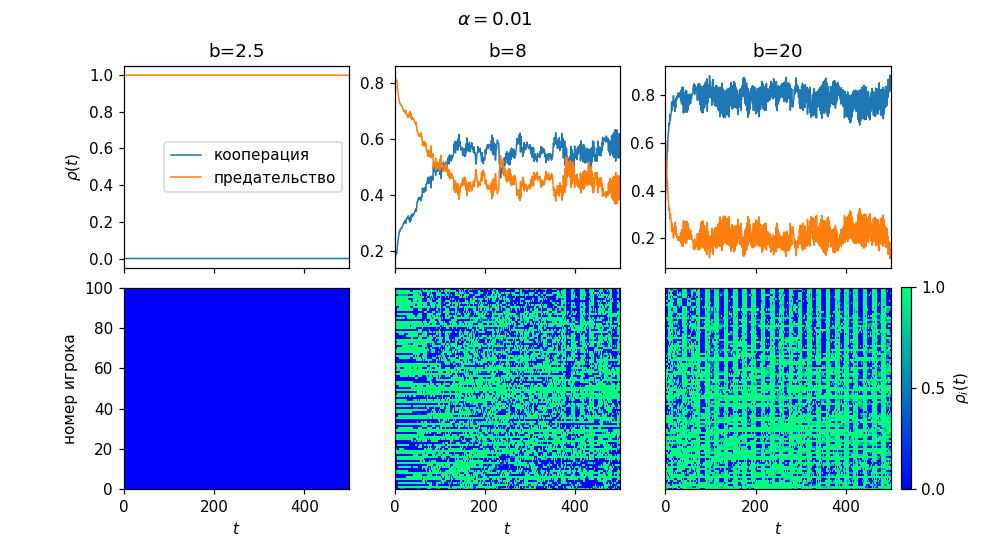

In [37]:
plot_2d([alpha], [2.5, 8, 20], [mono_res_low, mono_res_mid, mono_res_high], np.array(degs), 100, coef=1)
# игроки большей степени выше

#1 passed in 296.57763051986694,  projected end in 0.0 minutes
time elapsed = 296.5898458957672
#1 passed in 300.22989201545715,  projected end in 0.0 minutes
time elapsed = 300.2383210659027
#1 passed in 299.7896327972412,  projected end in 0.0 minutes
time elapsed = 299.79735708236694


<IPython.core.display.Javascript object>


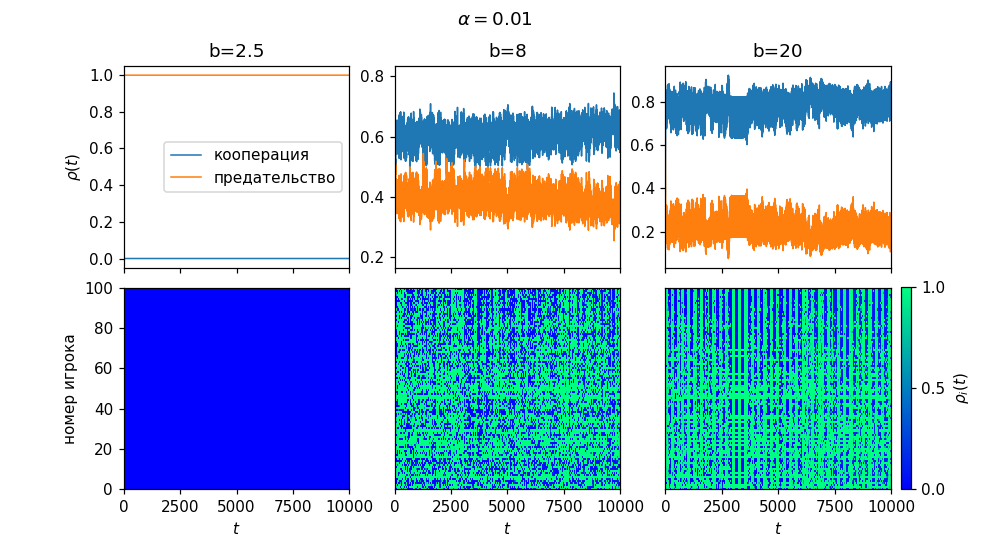

In [29]:
T = 10000
mono_res_low = calc('mono', [alpha], [2.5], [graph], T, set_builder=total, keys=['rho'] + list(range(100)))
mono_res_high = calc('mono', [alpha], [20], [graph], T, set_builder=total, keys=['rho'] + list(range(100)))
mono_res_mid = calc('mono', [alpha], [8], [graph], T, set_builder=total, keys=['rho'] + list(range(100)))
plot_2d([alpha], [2.5, 8, 20], [mono_res_low, mono_res_mid, mono_res_high], np.array(degs), 100, coef=1)
# игроки большей степени выше